In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

# from qiskit import *
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, execute, assemble, transpile
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.visualization import plot_state_qsphere, plot_state_city, plot_bloch_multivector
from qiskit.visualization import array_to_latex
import qiskit.quantum_info as qi
# from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit_ionq import IonQProvider
# import gates
from qiskit_ionq import GPIGate, GPI2Gate, MSGate
from qiskit import Aer, execute, assemble
from qiskit.providers.jobstatus import JobStatus
import time

from pipeline.qiskit_circuit_constructor import qiskit_alice_prepares, qiskit_measurement_prep, qiskit_clone, construct_qiskit_circuit
from pipeline.ionq_circuit_constructor import ionq_alice_prepares
from pipeline.ionq_circuit_constructor import ionq_measurement_prep
from pipeline.ionq_circuit_constructor import ionq_clone
from pipeline.ionq_circuit_constructor import construct_ionq_circuit
#from pipeline.run_experiments import fidelities
#from pipeline.run_experiments import get_circuit
#from pipeline.run_experiments import run_experiment_ionq
#from pipeline.run_experiments import run_simulation

provider = IonQProvider("RmK0yNkCDPmoxCH12uQ4U67lpu9kFgik")
native_simulator = provider.get_backend("ionq_simulator", gateset="native")
native_qpu = provider.get_backend("ionq_qpu", gateset="native")

ionq_sim = provider.get_backend("ionq_simulator")
ionq_qpu = provider.get_backend("ionq_qpu")

**Retrieving Data** The next function retrieves the data from IonQ and returns a list that contains the IonQ job number, the cloning angle, shot count, the experimental results, and the fidelities observed by Bob and Eve. This data will be stored in an Excel file.

In [2]:
def retrieve_data(job_num, angle, bitval, shot_count):
    ionq = provider.get_backend("ionq_qpu")
    retrieved = ionq.retrieve_job(job_num) 
    counts = retrieved.result().get_counts()
    
    out000 = retrieved.result().get_counts().get("000")
    out001 = retrieved.result().get_counts().get("001")
    out010 = retrieved.result().get_counts().get("010")
    out011 = retrieved.result().get_counts().get("011")
    out100 = retrieved.result().get_counts().get("100")
    out101 = retrieved.result().get_counts().get("101")
    out110 = retrieved.result().get_counts().get("110")
    out111 = retrieved.result().get_counts().get("111")
    
    if out000 == None:
        out000 = 0
    if out001 == None:
        out001 = 0
    if out010 == None:
        out010 = 0
    if out011 == None:
        out011 = 0
        
    if out100 == None:
        out100 = 0
    if out101 == None:
        out101 = 0
    if out110 == None:
        out110 = 0
    if out111 == None:
        out111 = 0
        
    B,E = fidelities(out000, out001, out010, out011, out100, out101, out110, out111, bitval, shot_count)
    
    row_data = [job_num, angle, shot_count, out000, out001, out010, out011, out100, out101, out110, out111, B, E]
        
    return row_data

**Fidelities** A function that calculates the fidelities observed by Bob and Eve in an experiment.

In [3]:
def fidelities(out000, out001, out010, out011, out100, out101, out110, out111, bitval, shots):
    '''
    This function averages the fidelity of the clones and ancilla over experiment.

    Parameters:
    --------------
    outijk -
    bitval -
    shots - Number of samples.

    Returns:
    --------------
    bob_fidelity - Fidelity of copy sent to intended recipient (Bob).
    eve_fidelity - Fidelity of copy kept by eavesdropper (Eve).
    ancilla_fidelity - Fidelity of the ancilla.
    
    '''
    
    if bitval == 1:
        bob_fidelity = (out001 + out011 + out101 + out111)/shots
        eve_fidelity = (out010 + out011 + out110 + out111)/shots
        #ancilla_fidelity = (out100 + out101 + out110 + out111)/shots
        
    if bitval == 0:
        bob_fidelity = (out010 + out000 + out110 + out100)/shots
        eve_fidelity = (out001 + out000 + out101 + out100)/shots
        #ancilla_fidelity = (out000 + out001 + out010 + out011)/shots
        
    return bob_fidelity, eve_fidelity

**Circuit Construction** Build the cloning circuit and make measurements.

In [4]:
def get_circuit(angle, bitval, basis):
    qc = QuantumCircuit(3,3)
    
    qc = qiskit_alice_prepares(qc, bitval, basis)
    qc.barrier()
    qc = qiskit_clone(qc, angle)
    qc.barrier()
    qc = qiskit_measurement_prep(qc, basis)
    
    qc.measure(0,0)
    qc.measure(1,1)
    qc.measure(2,2)
    return qc

**Experiment Submission** A function for submitting the experiment to the IonQ QPU.

In [6]:
def experiment_qpu(angle, bitval, basis, shot_count):
    qc = get_circuit(angle, bitval, basis)
    
    ionq_qpu = provider.get_backend("ionq_qpu")
    job = ionq_sim.run(qc, shots = shot_count)

    job_data = [job.job_id(), angle, bitval, basis, shot_count]
    
    return job_data

In [7]:
# select the number of sample points
N = 100

In [9]:
# We randomly (and uniformly) select angles from the interval [0, pi/4]. We sort the angles for convenience.
Angles = np.random.uniform(0, np.pi/4, N)
Angles = np.sort(Angles)

**Description of Experiment** Rather than submit roughly 1000 shots at 20 linearly spaced angles, we obtain a better curve if we use 100 randomly selected angles and 100 shots per angle. We print the job numbers out so that we have a record of those available. We also save the data into a csv file so that we can recover them later.

In [10]:
header = ['Job Number', 'Angle', 'Bit Value', 'Basis', 'Total Shots']

with open('QPU_Experiment_Qiskit_May_26_2023_2.csv', 'w', encoding = 'UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    
    for j in range(N):
        job_data = experiment_qpu(Angles[j], 0, 'X', 100)
        writer.writerow(job_data)
        print(job_data)
        
    f.close()  

['719d0a4c-a2c3-48c4-a65c-0bf81523baec', 0.0025086827017239354, 0, 'X', 100]
['4b63f0cc-8f9d-4df3-a7b9-9841817464f5', 0.02988780681441227, 0, 'X', 100]
['18df9b75-2ade-4493-8b7a-7bc054b14365', 0.04087557745421404, 0, 'X', 100]
['ce97501e-3830-4443-b96a-c8bba7431c14', 0.04359161598419652, 0, 'X', 100]
['6db71dc0-36f0-4691-b7ed-89f0eab7f9ec', 0.05170389068467869, 0, 'X', 100]
['edd0d4d2-f16f-4e79-ba0d-790c749e30b8', 0.06677203521254203, 0, 'X', 100]
['bd08644d-4124-408c-835c-1533b29cc864', 0.08995731253084858, 0, 'X', 100]
['7f2ea544-df9a-4c1b-88b1-bcafa2f29be5', 0.1008124602927869, 0, 'X', 100]
['d6f4518d-0486-4be8-b9c4-78680314e5a8', 0.10540129271888089, 0, 'X', 100]
['10d74cb0-fa6d-4e9b-995f-9e018dd34c0b', 0.11177437679363242, 0, 'X', 100]
['ac830d5e-f164-4a61-904d-c9cb98957463', 0.11907242523540207, 0, 'X', 100]
['4680e4d1-a8ef-4342-ba56-3b04c3a071c9', 0.12159610708179638, 0, 'X', 100]
['a6f70b63-479c-4027-bae9-099ac95b512d', 0.1305977536729061, 0, 'X', 100]
['1447319b-6fc9-4a17-b57a

In [12]:
Jobs_Data = pd.read_csv('QPU_Experiment_Qiskit_May_26_2023_2.csv')
JobNumbers = Jobs_Data.iloc[:, 0]

**Data Retrieval** We now begin the process of retrieving data from IonQ and populating the csv file that we've built.

In [13]:
header = ['Job Number', 'Angle','Total Shots', '000', '001', '010', '011', '100', '101', '110', '111', 'Bobs Fidelity', 'Eves Fidelity']

with open('QPU_Experiment_Qiskit_May_26_2023_2.csv', 'w', encoding = 'UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)

    for j in range(len(JobNumbers)):
        row_data = retrieve_data(JobNumbers[j], Angles[j], 0, 100)
        writer.writerow(row_data)

    f.close()

In [14]:
Completed_Job_Data = pd.read_csv('QPU_Experiment_Qiskit_May_26_2023_2.csv')
Completed_Job_Data

,Job Number,Angle,Total Shots,000,001,010,011,100,101,110,111,Bobs Fidelity,Eves Fidelity
0,719d0a4c-a2c3-48c4-a65c-0bf81523baec,0.002509,100,50,0,0,0,0,50,0,0,0.50,1.00
1,4b63f0cc-8f9d-4df3-a7b9-9841817464f5,0.029888,100,53,0,0,0,0,47,0,0,0.53,1.00
2,18df9b75-2ade-4493-8b7a-7bc054b14365,0.040876,100,54,0,0,0,0,46,0,0,0.54,1.00
3,ce97501e-3830-4443-b96a-c8bba7431c14,0.043592,100,54,0,0,0,0,46,0,0,0.54,1.00
4,6db71dc0-36f0-4691-b7ed-89f0eab7f9ec,0.051704,100,55,0,0,0,0,45,0,0,0.55,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,d16b10c2-4a94-4ee3-b132-43beb55b8582,0.769009,100,52,0,0,0,0,0,48,0,1.00,0.52
96,39094156-6592-4b5e-82c7-0d5e150e4d7a,0.778923,100,51,0,0,0,0,0,49,0,1.00,0.51
97,b8024115-f0ef-43c7-8f73-2e8760b92e8c,0.780354,100,51,0,0,0,0,0,49,0,1.00,0.51
98,3f81416f-55c6-4c59-8750-762bc440d3e3,0.782159,100,50,0,0,0,0,0,50,0,1.00,0.50


In [15]:
JobAngles = Completed_Job_Data.iloc[:, 1]
BobFidelity = Completed_Job_Data.iloc[:, 11]
EveFidelity = Completed_Job_Data.iloc[:, 12]

In [16]:
JobAngles = np.array(JobAngles)
BobFidelity = np.array(BobFidelity)
EveFidelity = np.array(EveFidelity)

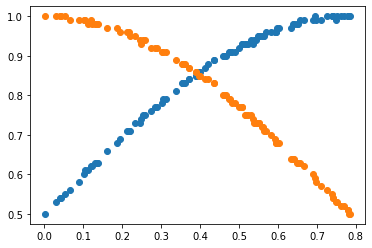

In [17]:
plt.figure()
plt.scatter(JobAngles, BobFidelity)
plt.scatter(JobAngles, EveFidelity)
plt.show()

In [18]:
Model_Bob = np.poly1d(np.polyfit(JobAngles, BobFidelity, 3))
Model_Eve = np.poly1d(np.polyfit(JobAngles, EveFidelity, 3))
Thetas = np.linspace(0, np.pi/4, 100)
Model_Bob_Curve = Model_Bob(Thetas)
Model_Eve_Curve = Model_Eve(Thetas)

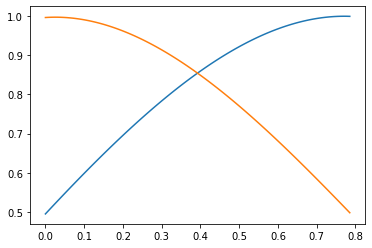

In [19]:
plt.figure()
plt.plot(Thetas, Model_Bob_Curve)
plt.plot(Thetas, Model_Eve_Curve)
plt.show()

**Information** The information is measured using the binary entropy. There's a nice description of how all this works in the book of Gilles van Assche.

In [20]:
Q = np.ones(N)
Q = Q - BobFidelity

In [21]:
def binary_entropy(t):
    if t == 0 or t == 1:
        return 0
    else:
        return -t * np.log2(t) - (1-t) * np.log2(1-t)

**Mutual Information between Alice and Bob**

In [22]:
def Info_AB(Q):
    return 1 - binary_entropy(Q)

**Mutual Information between Alice and Eve**

In [23]:
def Info_AE(Q):
    return 1 - binary_entropy(0.5 - np.sqrt(Q * (1-Q)))

In [26]:
IAB_exp = np.zeros(N)
IAE_exp = np.zeros(N)
for j in range(N):
    IAB_exp[j] = Info_AB(Q[j])
    IAE_exp[j] = Info_AE(Q[j])

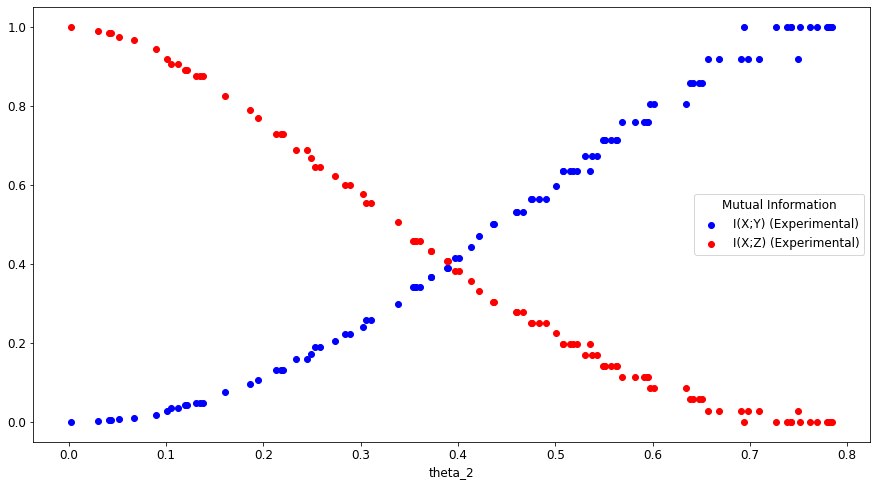

In [27]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 12})
plt.scatter(JobAngles, IAB_exp, label = "I(X;Y) (Experimental)",color='blue')
plt.scatter(JobAngles, IAE_exp, label = "I(X;Z) (Experimental)",color='red')
#plt.yticks(np.arange(0,1.1, step = .1))
#plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Mutual Information")

plt.xlabel('theta_2')
plt.show()

In the figure above of mutual information, $X$ is the random variable for Alice, $Y$ is the random variable for Bob, and $Z$ is the random variable corresponding to Eve. This means that $I(X;Y)$ is the mutual information between Alice and Bob and $I(X;Z)$ is the information between Alice and Eve. That is, $I(X;Z)$ measures the amount of information that Eve obtains during the eavesdropping process. From a security perspective, Alice and Bob need to have more information than that which is shared with Eve in order to be able to distill a secrret key.

In [47]:
Model_IAB = np.poly1d(np.polyfit(Angles, IAB_exp, 7))
Model_IAE = np.poly1d(np.polyfit(Angles, IAE_exp, 7))
Thetas = np.linspace(0, np.pi/4, 200)
Model_IAB_curve = Model_IAB(Thetas)
Model_IAE_curve = Model_IAE(Thetas)

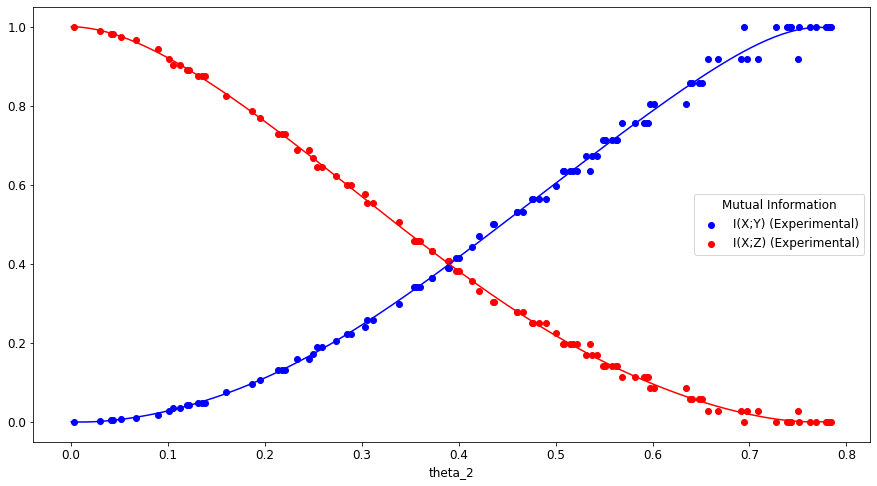

In [48]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 12})
plt.scatter(JobAngles, IAB_exp, label = "I(X;Y) (Experimental)",color='blue')
plt.scatter(JobAngles, IAE_exp, label = "I(X;Z) (Experimental)",color='red')
plt.plot(Thetas, Model_IAB_curve, color = 'blue')
plt.plot(Thetas, Model_IAE_curve, color = 'red')
#plt.yticks(np.arange(0,1.1, step = .1))
#plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Mutual Information")

plt.xlabel('theta_2')
plt.show()

**The error rate** We find that the the mutual information shared by Alice and Bob is higher than the mutual information between Alice and Eve if the angle is taken to the right of the intersection of the curves in the diagram above. We can find the intersection of the curves and then compute Bob's theoretical fidelity at this angle to obtain an error rate that Alice and Bob must attain to be able to distill a secure key.

In [51]:
# Error rate
def error_rate_theory(theta):
    return 0.5 - 0.5*np.sin(2 * theta)

In [50]:
ModelDiff = Model_IAB - Model_IAE
Roots = np.roots(ModelDiff)
RealRoots = Roots[~np.iscomplex(Roots)]
for j in range(len(RealRoots)):
    if RealRoots[j] >= 0 and RealRoots[j] <= np.pi/4:
        print('theta2 =', RealRoots[j])
        print('error rate =', error_rate_theory(RealRoots[j]))

theta2 = (0.39016877892704205+0j)
error rate = (0.14824032321175495+0j)


**Secret Key Distillation Rate** There is a link between the secret key distillation rate and the error rate here that is described in van Assche's book.